In [2]:

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import pandas as pd
from skimage import io, measure, filters, transform, morphology

pixel_size = 0.161 # µm per pixel

In [9]:
def plotting_style():
    """
    Sets matplotlibs plotting style to the publication default. It returns a
    list of the preferred colors.
    """
    rc = {'axes.facecolor': '#e7d8b8',
          'axes.grid': False,
          'axes.frameon': True,
          'ytick.direction': 'out',
          'xtick.direction': 'out',
          'xtick.gridOn': True,
          'ytick.gridOn': True,
          'ytick.major.width':5,
          'xtick.major.width':5,
          'ytick.major.size': 5,
          'xtick.major.size': 5,
          'mathtext.fontset': 'stixsans',
          'mathtext.sf': 'sans',
          'legend.frameon': True,
          'legend.facecolor': '#FFEDCE',
          'figure.dpi': 150,
          'xtick.color': 'k',
          'ytick.color': 'k'}
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('mathtext', fontset='stixsans', sf='sans')
    sns.set_style('dark', rc=rc)
    mpl.rcParams['image.cmap'] = 'gray'
    mpl.rcParams['xtick.labelsize']=16
    mpl.rcParams['ytick.labelsize']=16
    mpl.rcParams['axes.labelsize']=20
    mpl.rcParams['figure.titlesize']=20

plotting_style()

def find_all_tiffs(root_directory):

    tiff_list = []

    for root_path, _, files in os.walk(root_directory):
        for f in files:
            if f.endswith('.tif'):
                tiff_list.append(os.path.join(root_path,f))

    return tiff_list

def filter_mts(image, block_size=5, mask_size=5, yen=False):
    image_norm = (image - image.min()) / (image.max() - image.min())

    thresh_niblack = filters.threshold_niblack(image_norm, window_size=block_size,
                                                k=0.001)

    # Rather than applying the threshold to the image to create a binary
    # image, the threshold array thresh_niblack thickens the MTs, reducing
    # filament break-up. This is used then in the Otsu thresholding to
    # produce the binary image.
    thresh_otsu = filters.threshold_otsu(thresh_niblack)
    im_thresh = (thresh_niblack > thresh_otsu)

    mask = morphology.square(mask_size)
    im_closed = morphology.closing(im_thresh, selem=mask)

    if yen==True:
        im_subt = image - im_closed
        im_yen = filters.threshold_yen(im_subt)
        im_filtered = im_subt > im_yen
    else:
        im_filtered = im_closed.copy()

    return im_filtered

def border_clear(im_label, edge=3):
    im_border = np.copy(im_label)

    border = np.ones(np.shape(im_label))
    border[edge:-1*edge,edge:-1*edge] -= 1

    for n in np.unique(im_border):
        if np.any(border * [im_border==n+1]):
            im_border[im_border==n+1] = 0

    return im_border

def determine_count_nums(im_label):
    unique, counts = np.unique(im_label, return_counts=True)

    return unique, counts

def remove_small(im_label, area_thresh=10):
    im_sized = np.copy(im_label)

    unique, counts = determine_count_nums(im_label)

    # Create dictionary except for 0 (background)
    dict_area = dict(zip(unique,counts))

    for label in unique:
        if label > 0 and dict_area[label]<=area_thresh:
            im_sized[im_sized==label] = 0
    
    return im_sized

def remove_circulars(im_label, eccen_thresh=0.8):
    im_eccen = im_label.copy()

    im_props = measure.regionprops_table(im_eccen,
                                        properties=['label','eccentricity'])
    df = pd.DataFrame(im_props)

    for n in np.unique(im_eccen):
        if df[df['label']==n]['eccentricity'].values < eccen_thresh:
            im_eccen[im_eccen==n] = 0

    return im_eccen

def are2lines(mt_segment, min_dist=9, min_angle=75):
    test_angles = np.linspace(-np.pi / 2, np.pi / 2, 360)
    h, theta, d = transform.hough_line(mt_segment, theta=test_angles)

    _, angles, _ = transform.hough_line_peaks(h, theta, d, 
                                                min_distance=min_dist,
                                                min_angle=min_angle,
                                                num_peaks=2)

    return len(angles)==2

def remove_line_crossovers(image, min_dist=9, min_angle=75, padding=3):
    im_cleaned = image.copy()

    for n in np.unique(image)[1:]:
        x,y = np.where(image==n)
        mt_segment = image[x.min()-padding:x.max()+padding,y.min()-padding:y.max()+padding]
        
        if are2lines(mt_segment, min_dist=min_dist, min_angle=min_angle):
            im_cleaned = np.where(im_cleaned==n, 0, im_cleaned)

    return im_cleaned

def process_mt_images(image, block_size=3, mask_size=3, count_thresh=200, edge=3, area_thresh=10, min_dist=9, min_angle=75, padding=3):
    im_filtered = filter_mts(image, block_size=block_size, mask_size=mask_size)
    im_label, n_labels = measure.label(im_filtered, return_num=True)
    # Determine if Yen thresholding background subtraction is necessary
    unique, _ = determine_count_nums(im_label)
    if unique[-1] > count_thresh:
        im_filtered = filter_mts(image, block_size=block_size, mask_size=mask_size, yen=True)
        im_label, n_labels = measure.label(im_filtered, return_num=True)
    im_internal = border_clear(im_label, edge=edge)
    im_sized = remove_small(im_internal, area_thresh=area_thresh)
    im_thinned = morphology.thin(im_sized)
    im_relabel = measure.label(im_thinned)
    im_noxovers = remove_line_crossovers(im_relabel, min_dist=min_dist,
                                        min_angle=min_angle, padding=padding)

    return im_noxovers

In [10]:
root = '/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/flow_paper/revision/MT_distribution'
tiff_list = find_all_tiffs(root)

In [11]:
df_props = pd.DataFrame()
for image_file in tiff_list:
    image = io.imread(image_file)
    im_processed = process_mt_images(image, block_size=3, 
                                    mask_size=3, edge=5, 
                                    area_thresh=10, min_dist=9,
                                    min_angle=75, padding=3)
    im_props = measure.regionprops_table(im_processed, image,
                                    properties=['area', 'major_axis_length',
                                                'minor_axis_length','centroid',
                                                'orientation', 'eccentricity',
                                                'label', 'perimeter'])
    _df = pd.DataFrame(im_props)
    _df['tiff_file'] = image_file
    # Remove non-existent objects from thinning to single-pixel size
    _df = _df[_df['perimeter']>0]
    _df['perimeter (um)'] = _df['perimeter'] * pixel_size
    df_props = df_props.append(_df, ignore_index=True)



/opt/anaconda3/envs/active_matters/lib/python3.9/site-packages/skimage/_shared/utils.py:274: FutureWarning: `selem` is a deprecated argument name for `closing`. It will be removed in version 1.0. Please use `footprint` instead.
  warnings.warn(self.warning_msg.format(
/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_64481/4131311015.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_props = df_props.append(_df, ignore_index=True)
/opt/anaconda3/envs/active_matters/lib/python3.9/site-packages/skimage/_shared/utils.py:274: FutureWarning: `selem` is a deprecated argument name for `closing`. It will be removed in version 1.0. Please use `footprint` instead.
  warnings.warn(self.warning_msg.format(
/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_64481/4131311015.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

In [12]:
df_props.to_csv('/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/flow_paper/revision/MT_distribution/MT_lengths.csv', sep=',')

In [ ]:
df_props = pd.read_csv('MT_lengths.csv')  
mt_length = np.sort(df_props['perimeter (um)'].values)
ecdf = np.arange(1, len(mt_length)+1, 1) /len(mt_length)

q_25 = np.percentile(mt_length, 25)
q_50 = np.percentile(mt_length, 50)
q_75 = np.percentile(mt_length, 75)

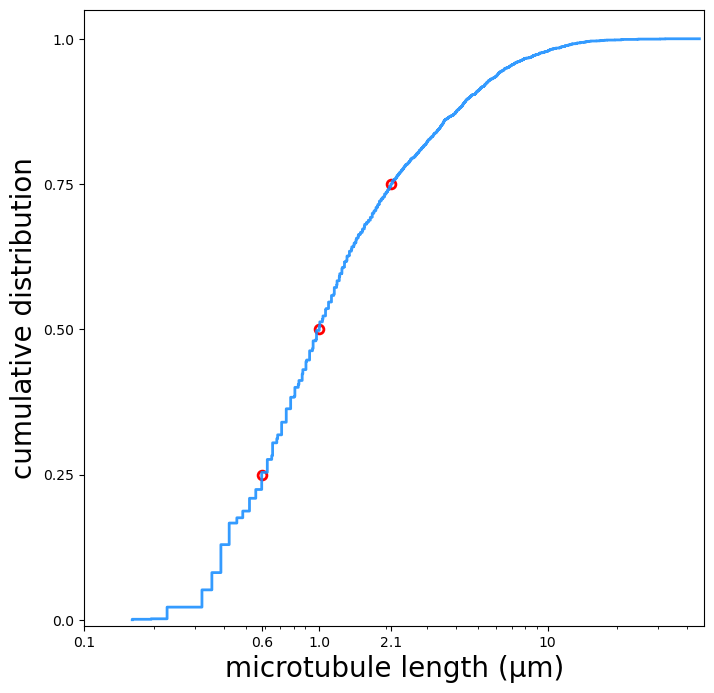

In [12]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

ax.step(mt_length, ecdf, color='dodgerblue', lw=2, zorder=4, alpha=0.9)

ax.scatter(q_25, 0.25, s=40, zorder=3, facecolor='w', edgecolor='red', lw=2)
ax.scatter(q_50, 0.50, s=40, zorder=3, facecolor='w', edgecolor='red', lw=2)
ax.scatter(q_75, 0.75, s=40, zorder=3, facecolor='w', edgecolor='red', lw=2)

#ax.axvline(q_25, 0, 0.25, color='dodgerblue', lw=2)
#ax.axvline(q_50, 0, 0.50, color='dodgerblue', lw=2)
#ax.axvline(q_75, 0, 0.75, color='dodgerblue', lw=2)

ax.set_xlim([0.1,np.max(mt_length)*1.05])
ax.set_ylim([-0.01,1.05])
ax.set_xlabel('microtubule length (µm)', fontsize=20)
ax.set_ylabel('cumulative distribution', fontsize=20)
#ax.legend(fontsize=14, loc=4)
ax.set_xscale('log')

ax.set_xticks([0.1, q_25, q_50, q_75, 10])
ax.set_xticklabels(['0.1', '%.1f' %q_25, '%.1f' %q_50, '%.1f' %q_75, '10'])

ax.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(['0.0', '0.25', '0.50', '0.75', '1.0'])

fig.savefig('MT_distribution.png')